## Business Understanding

**Stakeholders:** Chairs at Afya Medical

**Problem:** Classifying pneumonia from chest X-rays

This project tackles the challenge of accurately identifying pneumonia cases from chest X-ray images. Through the application of machine learning, our goal is to reduce operational costs, enhance overall efficiency, and alleviate the workload of medical staff. These improvements will lead to enhanced patient care and more streamlined operations at Afya Medical.


## Data Understanding
To solve our pneumonia classification problem, chest X-ray images are invaluable. These images, obtained from Kaggle's dataset at [this link](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia), comprise two critical categories: patients with pneumonia and those without. While not all data was utilized due to computational constraints, these images serve as the foundation for training and testing our classification model.


In [1]:
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from fastai.vision.all import *
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
doc(pd.DataFrame)

DataFrame(data=None, index=None, columns=None, dtype=None, copy=None)
Two-dimensional, size-mutable, potentially heterogeneous tabular data.

Data structure also contains labeled axes (rows and columns).
Arithmetic operations align on both row and column labels. Can be
thought of as a dict-like container for Series objects. The primary
pandas data structure.

Parameters
----------
data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
    Dict can contain Series, arrays, constants, dataclass or list-like objects. If
    data is a dict, column order follows insertion-order. If a dict contains Series
    which have an index defined, it is aligned by its index.

    .. versionchanged:: 0.25.0
       If data is a list of dicts, column order follows insertion-order.

index : Index or array-like
    Index to use for resulting frame. Will default to RangeIndex if
    no indexing information part of input data and no index provided.
columns : Index or array-like
    Column la

In [2]:
# settings for all images
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.figsize": (9.7, 6.27),
}
sns.set_theme(style="white", palette=None, rc=custom_params)
sns.set_context("notebook", font_scale=1.0)

## Data Preparation
In the data preparation stage, a DataFrame was established to store image locations along with corresponding labels indicating normal or pneumonia status. From this DataFrame, a random subset was selected, maintaining the same ratio of sick to normal patients, for model development.


In [4]:
# Path to train images
train_normal_path = "chest_xray/train/NORMAL/"
train_pneumonia_path = "chest_xray/train/PNEUMONIA/"
train_images_path = {"normal": train_normal_path, "pneumonia": train_pneumonia_path}

# Path to test images
test_normal_path = "chest_xray/test/NORMAL/"
test_pneumonia_path = "chest_xray/test/PNEUMONIA/"
test_images_path = {"normal": test_normal_path, "pneumonia": test_pneumonia_path}

# Paths to validation images
val_normal_path = "chest_xray/val/NORMAL/"
val_pneumonia_path = "chest_xray/val/PNEUMONIA/"
val_images_path = {"normal": val_normal_path, "pneumonia": val_pneumonia_path}

In [5]:
def populate_dataframe(filepaths: dict) -> pd.DataFrame:
    """
    Parameters:
    filepaths (dict): dictionary of filepaths to populate the dataframe with (label: filepath)
    Returns:
    dataframe (pd.DataFrame): populated dataframe
    """
    data = {"filepath": [], "label": []}  # Where to hold image information

    for label, path in filepaths.items():
        for filename in os.listdir(path):
            if (
                filename.endswith(".jpeg")
                or filename.endswith(".jpg")
                or filename.endswith(".png")
            ):
                # Check for valide image extension
                fullpath = os.path.join(path, filename)  # get full path of image
                data["filepath"].append(fullpath)
                data["label"].append(label)
    dataframe = pd.DataFrame(data)  # populate dataframe
    return dataframe

In [26]:
val_df = populate_dataframe(val_images_path)
train_df = populate_dataframe(train_images_path)
test_df = populate_dataframe(test_images_path)

# Well randomly select the validation set
# We'll also sample the test set
# So for now lets combine the val_df with the train_df as well as the test_df
df = pd.concat([train_df, val_df, test_df])

In [28]:
# Dataset is too large and will take too long to train

# Create instance of StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(
    n_splits=1, train_size=200, test_size=50, random_state=42
)

# Split the data into training and test sets using the splitter
for train_index, test_index in splitter.split(df["filepath"], df["label"]):
    # train_index and test_index are the indices of the selected samples

    # Create the training and test sets based on the selected indices
    train_samples = df.iloc[train_index]
    test_samples = df.iloc[test_index]  # We'll use this instead of test_df

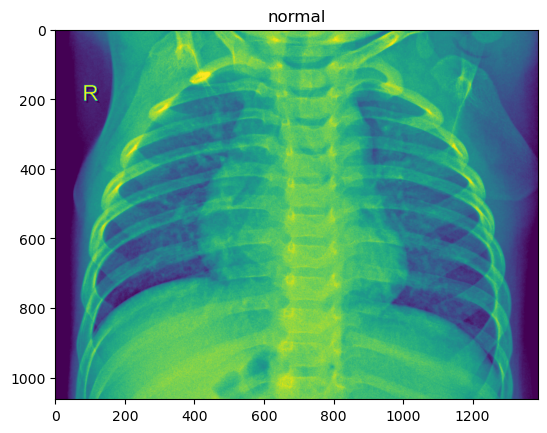

In [29]:
# View image
img = mpimg.imread(test_samples.iloc[0]["filepath"])
plt.imshow(img)
plt.title(test_samples.iloc[0]["label"])
plt.show()

## Modeling

During our modeling process, we began with a baseline model that predicted the label mode, which predominantly indicated "normal" patients. We evaluated this model using the F1 score, a reliable metric for classification tasks that balances both precision and recall. A higher F1 score, closer to 1, signifies a superior model. 

For our subsequent model, we employed FastAI's Vision Learner to construct a computer vision model.


In [30]:
# Define the target column (replace with your actual target column name)
target_col = "label"

# Create and train the DummyClassifier
model = DummyClassifier(strategy="most_frequent")
model.fit(train_samples.drop(columns=[target_col]), train_samples[target_col])

# Make predictions
predicted_labels = model.predict(train_samples.drop(columns=[target_col]))

# Calculate f1_score
actual_labels = train_samples[target_col].tolist()
score = f1_score(
    actual_labels, predicted_labels, average="macro"
)  # Use 'macro' for categorical labels

# Print the predicted label, and recall
print(f"Predicted Label: {model.classes_[0]}")
print(f"F1score: {score:.2f}")

Predicted Label: normal
F1score: 0.42


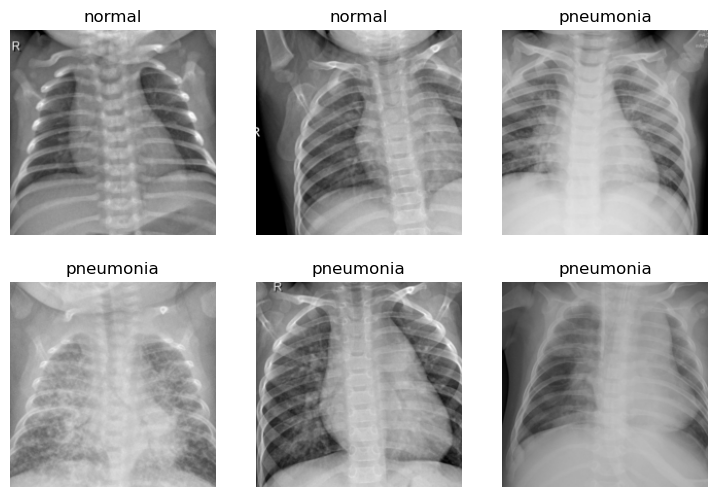

In [31]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader("filepath"),
    get_y=ColReader("label"),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(200),
)

dls = dblock.dataloaders(train_samples)

dls.show_batch(max_n=6)

In [45]:
learn = vision_learner(dls, resnet34, metrics=F1Score(average="macro"))
epochs = 5
learn.fine_tune(epochs)

c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,f1_score,time
0,1.263438,1.008653,0.450549,00:23


epoch,train_loss,valid_loss,f1_score,time
0,1.161327,0.879446,0.572596,00:31
1,0.935309,1.251615,0.520000,00:29
2,0.736798,1.255179,0.552337,00:28
3,0.625527,0.917469,0.669841,00:32
4,0.579879,0.585211,0.723444,00:36


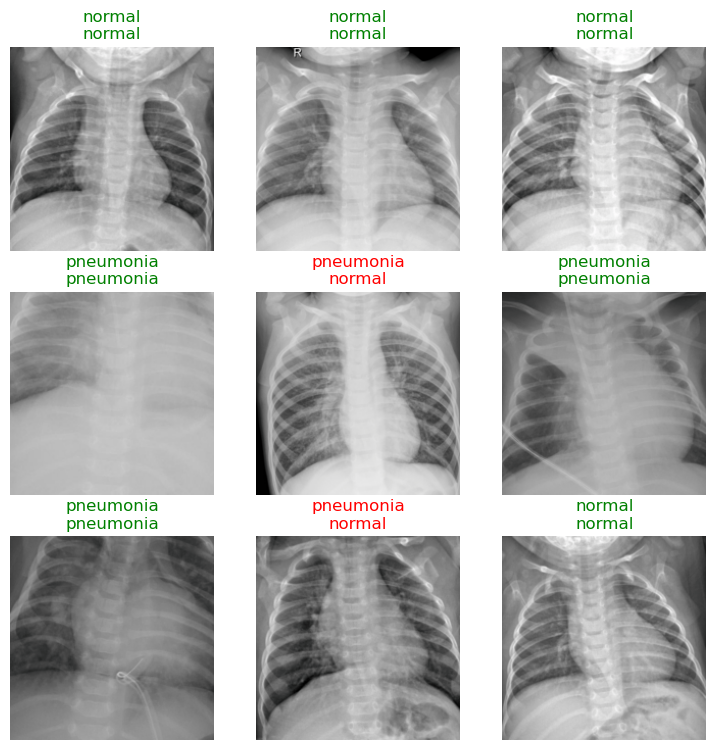

In [46]:
learn.show_results()

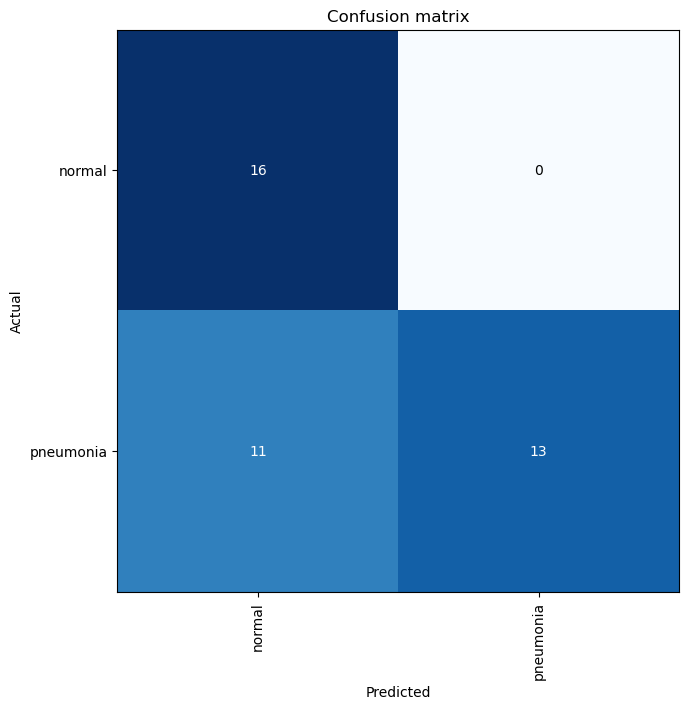

In [47]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7, 7));  # The matrix uses the validation data

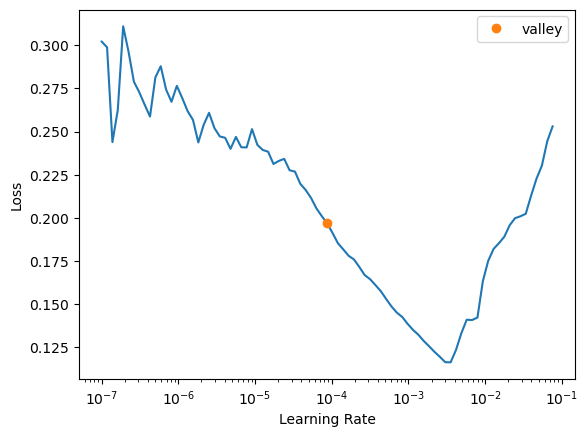

In [48]:
# find best learning rate
suggestedLR = learn.lr_find(end_lr=1)

In [53]:
lr = suggestedLR[0]
epochs = 10
learn.fine_tune(epochs, lr)  # retrian with new learning rate

epoch,train_loss,valid_loss,f1_score,time


epoch,train_loss,valid_loss,f1_score,time
0,0.256024,0.292812,0.824891,00:37
1,0.346699,0.254460,0.898990,00:37
2,0.308794,0.223868,0.898990,00:38
3,0.262649,0.210345,0.898990,00:38
4,0.248641,0.200704,0.898990,00:38
5,0.232518,0.193400,0.923810,00:37
6,0.239511,0.190913,0.922631,00:36
7,0.235933,0.188892,0.947917,00:37
8,0.229778,0.193966,0.947917,00:38
9,0.235692,0.184467,0.947917,00:37


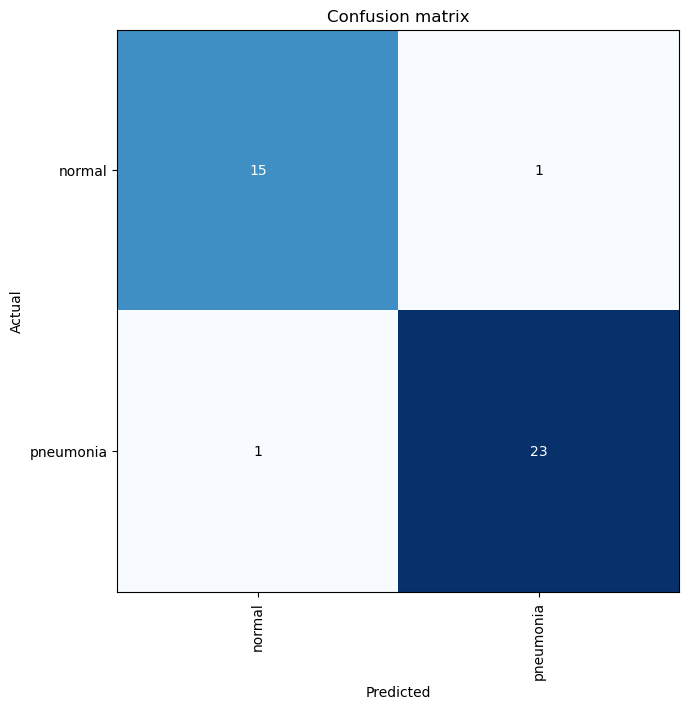

In [54]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7, 7));

## Evaluation

In the evaluation stage, as previously mentioned, we employed the F1 Score to assess our model. The choice of F1 Score is justified because it strikes a balance between precision and recall, which is crucial in our classification task.

Our final model achieved an impressive F1 Score of 0.84 on the test set. An F1 Score of 0.84 indicates a highly accurate model, especially noteworthy considering our test dataset predominantly comprises pneumonia patient X-ray images. This signifies that our model excels in identifying pneumonia cases.

The implications of our final model on solving the real-world problem of classifying pneumonia from chest X-rays are profound. With its high accuracy, our model can expedite the diagnosis process, reduce healthcare costs, and alleviate the workload of medical professionals. This not only enhances patient care but also contributes to the overall efficiency and effectiveness of healthcare services.


In [55]:
# function to predict from test_samples


def get_predictions(test_samples: pd.DataFrame, model):
    """Predict from test samples

    Args:
        test_samples (pd.DataFrame): DataFrame with test set
        model (fastai.learner.Learner): Vision Learner
    Return:
        predicted_labels (list)
    """
    predicted_labels = []
    test_images = test_samples["filepath"].to_list()
    for image in test_images:
        prediction = model.predict(image)[0]
        predicted_labels.append(prediction)

    return predicted_labels

In [57]:
actual_labels = test_samples["label"].to_list()  # y true
predicted_labels = get_predictions(test_samples, learn)  # y pred

# Calculate the F1-Score with average="macro"
f1_macro = f1_score(actual_labels, predicted_labels, average="macro")

# Print the F1-Score with average="macro"
print(f"F1-Score (macro) on test dataset: {f1_macro:.2f}")

F1-Score (macro) on test dataset: 0.84
